In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error
)
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings("ignore")

def convert_sqft(value):
    value = str(value).strip()

    if "-" in value:
        parts = value.split("-")
        nums = [float(p) for p in parts]
        return np.mean(nums)
    else:
        return pd.to_numeric(value, errors='coerce')

df = pd.read_csv('Bangalore house data.csv')

# preprocessing
df['total_sqft'] = df['total_sqft'].apply(convert_sqft)

# fill the null values
df['location'] = df['location'].fillna(df['location'].mode()[0])
df['size'] = df['size'].fillna(df['size'].mode()[0])
df['society'] = df['society'].fillna(df['society'].mode()[0])
df['bath'] = df['bath'].fillna(float(int(df['bath'].mean())))
df['balcony'] = df['balcony'].fillna(float(int(df['balcony'].mean())))


# outlier removal
idx_to_rm = list(df[df['bath'] >= 5].index)
df = df.drop(idx_to_rm, axis = 0)

# making the size column uniform
df['size_clean'] = df['size'].apply(
    lambda x: str(pd.to_numeric(x.split()[0], errors='coerce')) + " BHK"
)
df['size_clean'].unique()

df['location'] = df['location'].astype(str).str.strip()
df['location'] = df['location'].str.replace(r'\s+', ' ', regex=True).str.strip()
df['society'] = df['society'].str.replace(r'[0-9 ]+', '', regex=True)
df['society'] = df['society'].str.capitalize()

df['location'] = df['location'].replace("2nd phase jp nagar, jp nagar", "2nd Phase JP Nagar")
df['location'] = df['location'].replace("Jaraganahalli Jp Nagar Post", "JP Nagar")
df['location'] = df['location'].replace("Annapoorneshwari Layout, JP nagar 7th phase", "7th Phase JP Nagar")
df['location'] = df['location'].replace("JP Nagar 7th Phase", "7th Phase JP Nagar")
df['location'] = df['location'].replace("JP Nagar 8th Phase", "8th Phase JP Nagar")
df['location'] = df['location'].replace("JP nagar 9th Phase", "9th Phase JP Nagar")

df.drop('size', axis = 1, inplace = True)

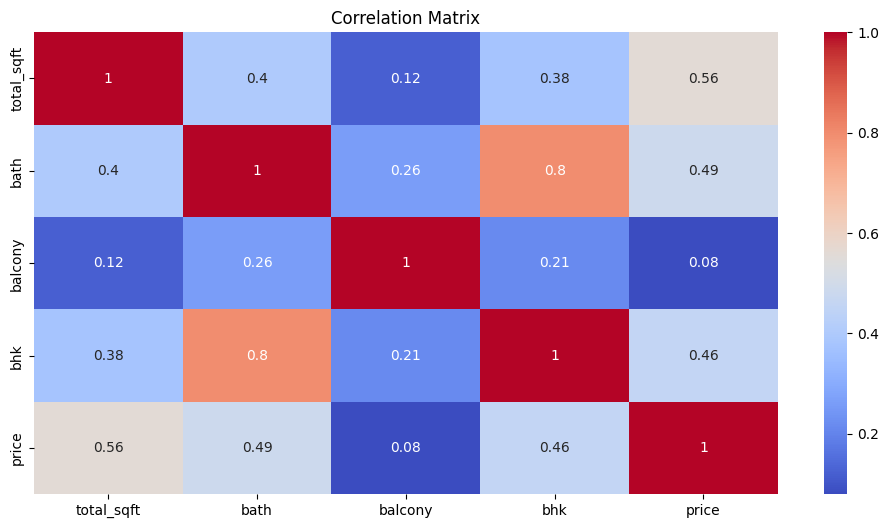

In [3]:
plt.figure(figsize=(12, 6))
sns.heatmap(df[["total_sqft","bath","balcony","bhk","price"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

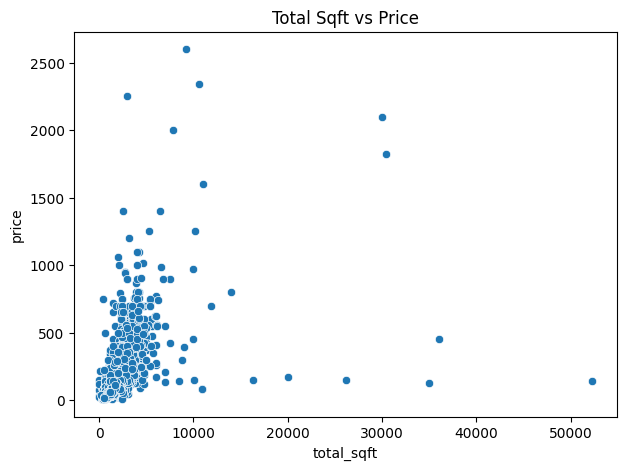

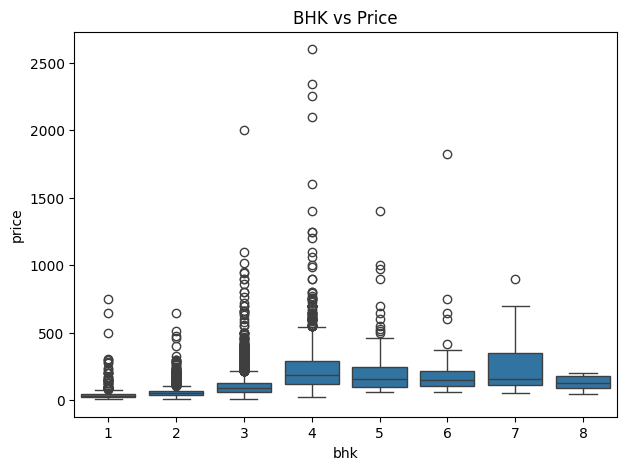

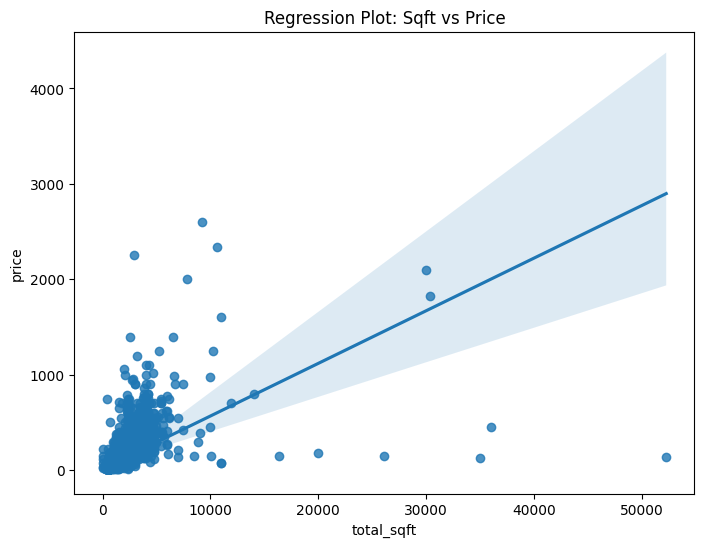

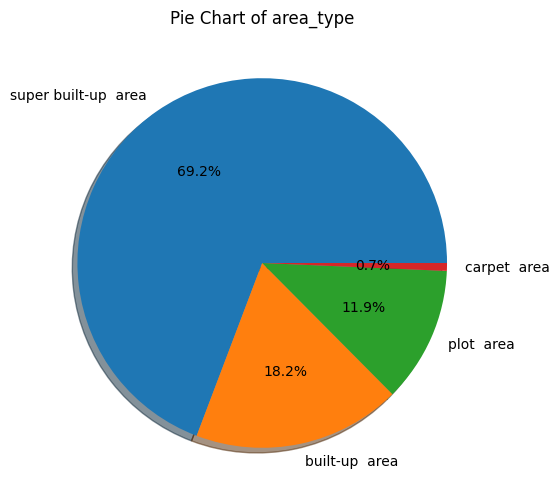

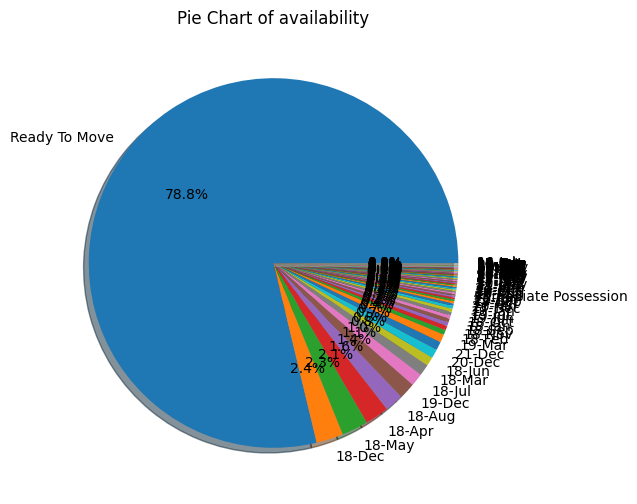

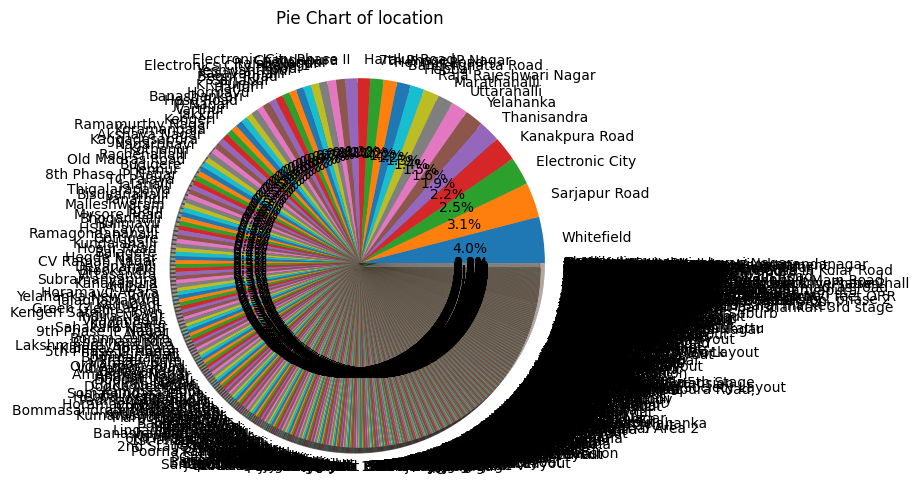

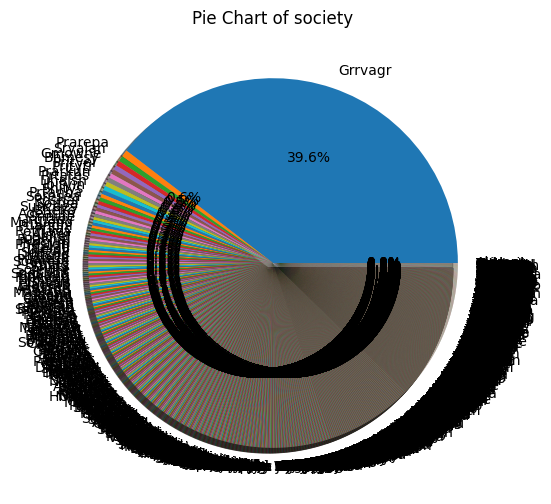

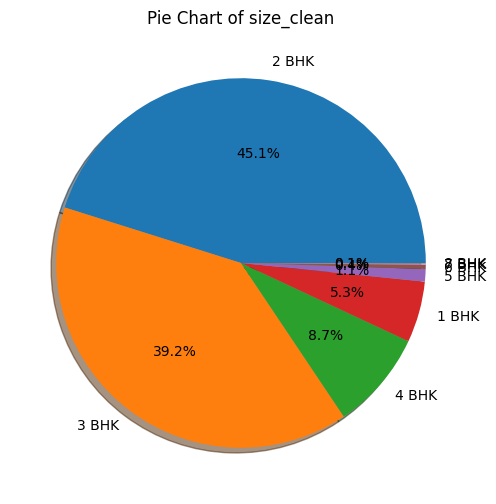

In [4]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x="total_sqft", y="price")
plt.title("Total Sqft vs Price")
plt.show()

plt.figure(figsize=(7, 5))
sns.boxplot(data=df, x="bhk", y="price")
plt.title("BHK vs Price")
plt.show()

plt.figure(figsize=(8, 6))
sns.regplot(x=df["total_sqft"], y=df["price"])
plt.title("Regression Plot: Sqft vs Price")
plt.show()

# Categorical columns (object type)
cat_cols = df.select_dtypes(include=['object']).columns

# Numerical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in cat_cols:
    plt.figure(figsize=(6, 6))
    df[col].value_counts().plot.pie(autopct="%1.1f%%", shadow=True)
    plt.title(f"Pie Chart of {col}")
    plt.ylabel("")   # remove unnecessary label
plt.show()

# plt.figure(figsize=(7, 5))
# sns.histplot(df["price"], bins=40)
# plt.title("Price Distribution")
# plt.show()

In [ ]:
feature_cols = [
    "area_type",
    "availability",
    "location",
    "society",
    "total_sqft",
    "bath",
    "balcony",
    "bhk",
    "price_per_sqft",
    # "society_development"
]

X = df[feature_cols]
y = df["price"]

categorical_cols = [
    "area_type",
    "availability",
    "location",
    "society",
    # "size_clean"

    # "society_development"
]

numeric_cols = [
    "total_sqft",
    "bath",
    "balcony",
    "bhk",
    "price_per_sqft"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

In [ ]:
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

param_grid = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1]
}

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb_reg)
])

search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions={"model__" + k: v for k, v in param_grid.items()},
    n_iter=20,
    scoring="r2",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# print("⏳ Running Hyperparameter Tuning...")
# search.fit(X_train, y_train)
# print("✔ Best parameters:", search.best_params_)

# pipeline = search.best_estimator_

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [16]:
xgb_params = {
    'subsample': 0.8, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1, "objective":"reg:squarederror", "random_state":42}

xgb_reg = xgb.XGBRegressor(**xgb_params)
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb_reg)
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

R2 = r2_score(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
MAE = mean_absolute_error(y_test, y_pred)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
# MI=mutual_info_regression(X,y)

print("\n===== FINAL MODEL ACCURACY =====")
print(f"R² Score       : {R2:.4f}")
print(f"RMSE           : {RMSE:.4f}")
print(f"MAE            : {MAE:.4f}")
print(f"MAPE (%)       : {MAPE:.2f}%")


===== FINAL MODEL ACCURACY =====
R² Score       : 0.9396
RMSE           : 26.5487
MAE            : 3.0570
MAPE (%)       : 2.34%


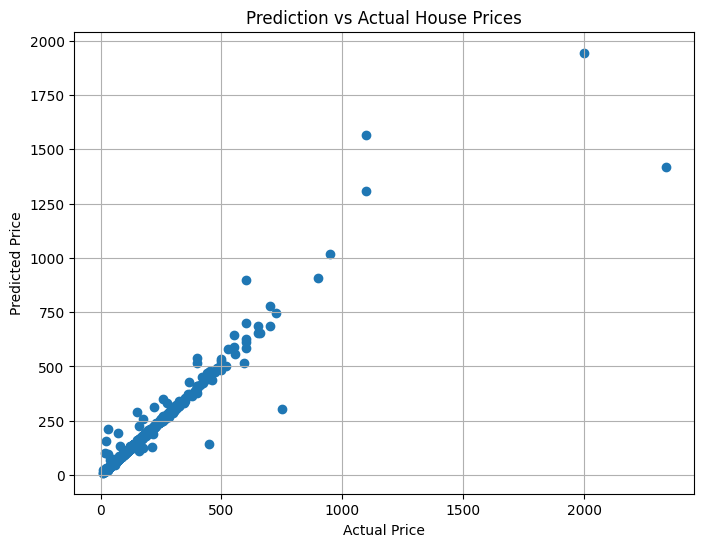

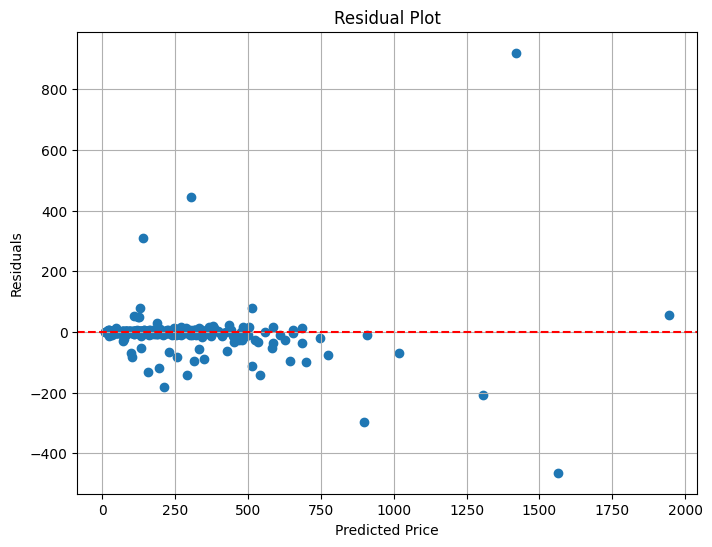

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Prediction vs Actual House Prices")
plt.grid(True)
plt.show()

# ----------------------------------------------------------
# 10. Residual Plot
# ----------------------------------------------------------
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

In [20]:
model = pipeline.named_steps["model"]
feature_names = (
    pipeline.named_steps["preprocessor"]
    .named_transformers_["cat"]
    .get_feature_names_out(categorical_cols).tolist()
    + numeric_cols
)

# plt.figure(figsize=(10, 8))
# plt.barh(feature_names, model.feature_importances_)
# plt.title("XGBoost Feature Importance")
# plt.xlabel("Importance Score")
# plt.show()

# ----------------------------------------------------------
# 12. Save Model
# ----------------------------------------------------------
joblib.dump(pipeline, "xgboost_house_price_model2.pkl")
print("\n💾 Model saved as xgboost_house_price_model2.pkl")


💾 Model saved as xgboost_house_price_model1.pkl
